In [1]:
# Install Kaggle API
!pip install kaggle
!pip install -q tensorflow
!pip install tensorflow
!pip install -q keras
!pip install seaborn


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [02:10<00:00, 41.6MB/s]
100% 5.20G/5.20G [02:10<00:00, 42.9MB/s]


In [5]:
!unzip -q /content/skin-cancer-mnist-ham10000.zip -d /content/ham10000

In [6]:
dataset_path = '/content/ham10000'

Importing libraries

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau



Using TensorFlow backend.

In [9]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Reading the Data

In [10]:
df = pd.read_csv('/content/ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [12]:
df.shape

(10015, 7)

**Data Preprocessing**

Creating dictionary for displaying more human-friendly labels.

In [13]:

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '/content/ham10000'

Merge images from both folders into one dictionary

In [14]:
import os
from glob import glob

base_skin_dir = '/content/ham10000'

# Use glob to get a list of file paths
image_paths = glob(os.path.join(base_skin_dir, '*', '*.jpg'))

# Create a dictionary mapping image IDs to file paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

Creating new columns for better understanding of features

In [15]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000/ham10000_images_part_1/ISIC_...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000/HAM10000_images_part_2/ISIC_...,Benign keratosis-like lesions,2


Data Cleaning

In [16]:
df.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [17]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [18]:
df.isna().sum().sum()

0

**Exploratory Data Analysis (EDA)**

Gender wise differentiability

<ipython-input-19-9f92caa76764>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sex',data=df, palette = 'Paired')


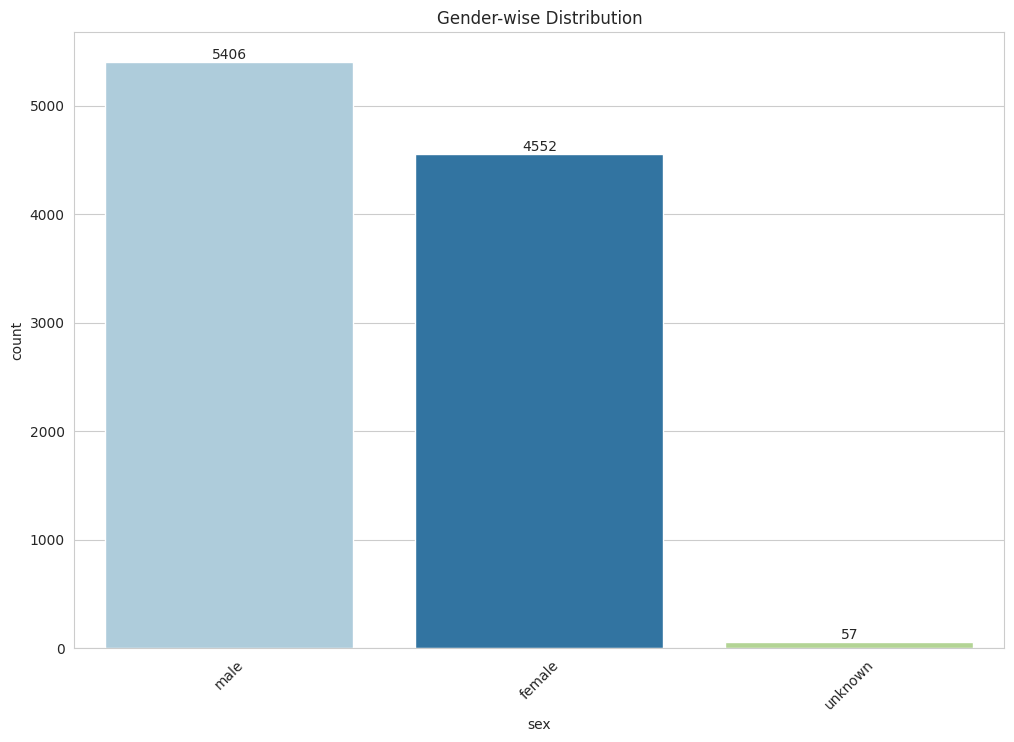

In [19]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='sex',data=df, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

Gender wise differentiability

<ipython-input-20-91834c66b92f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')


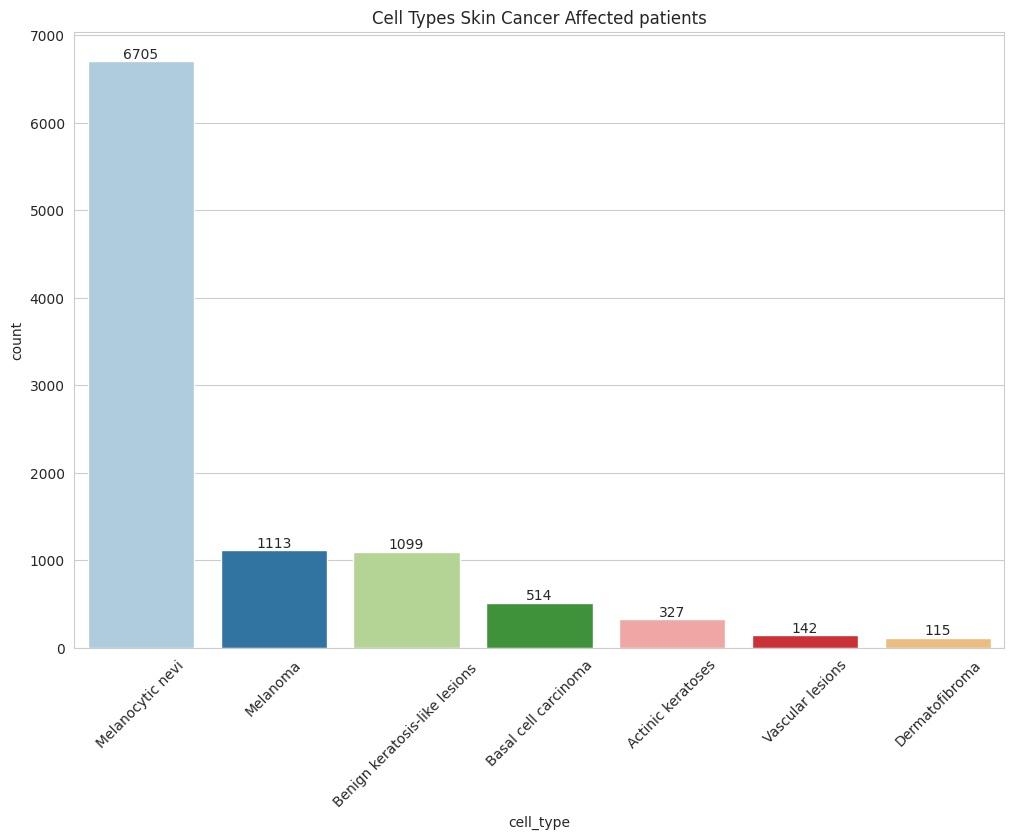

In [20]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

Gender vs Cell type

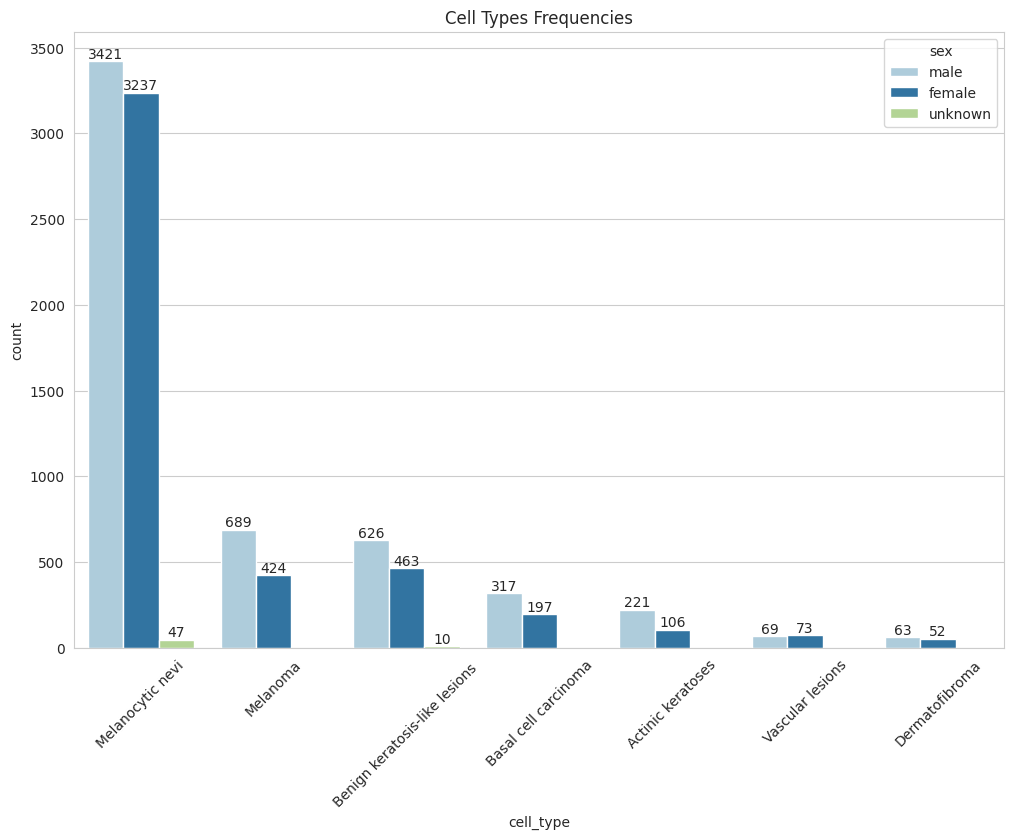

In [21]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

Cell Type

<ipython-input-22-8388bbb505b4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')


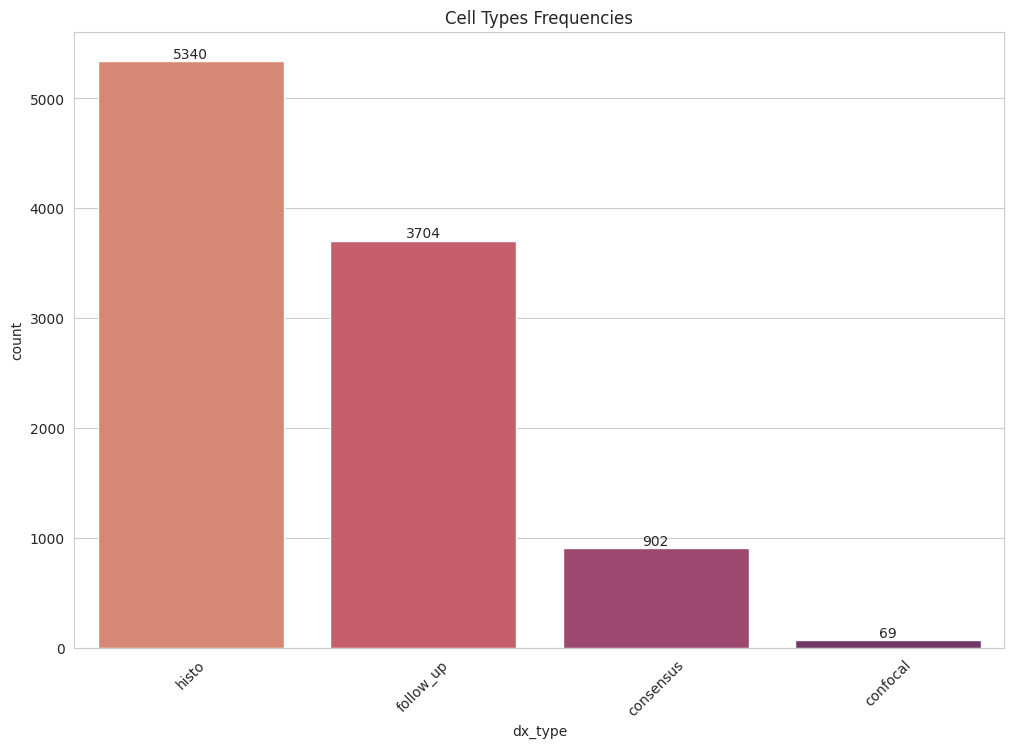

In [22]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

Gender wise Cell Type Distribution

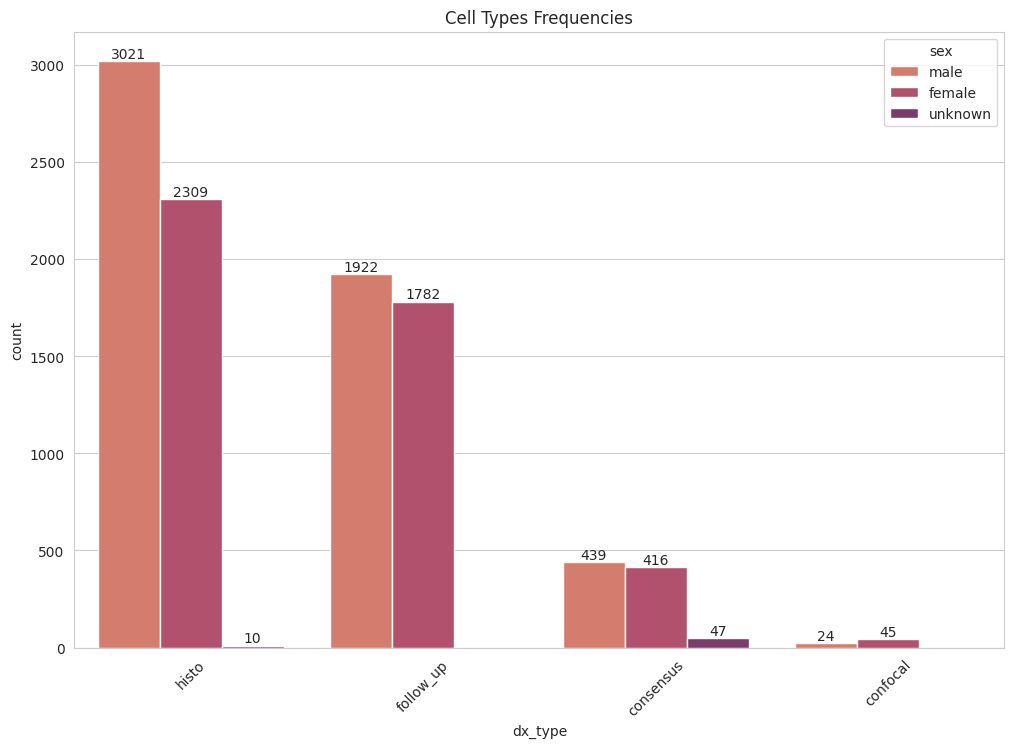

In [23]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',hue='sex', data=df, order = df['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

Age

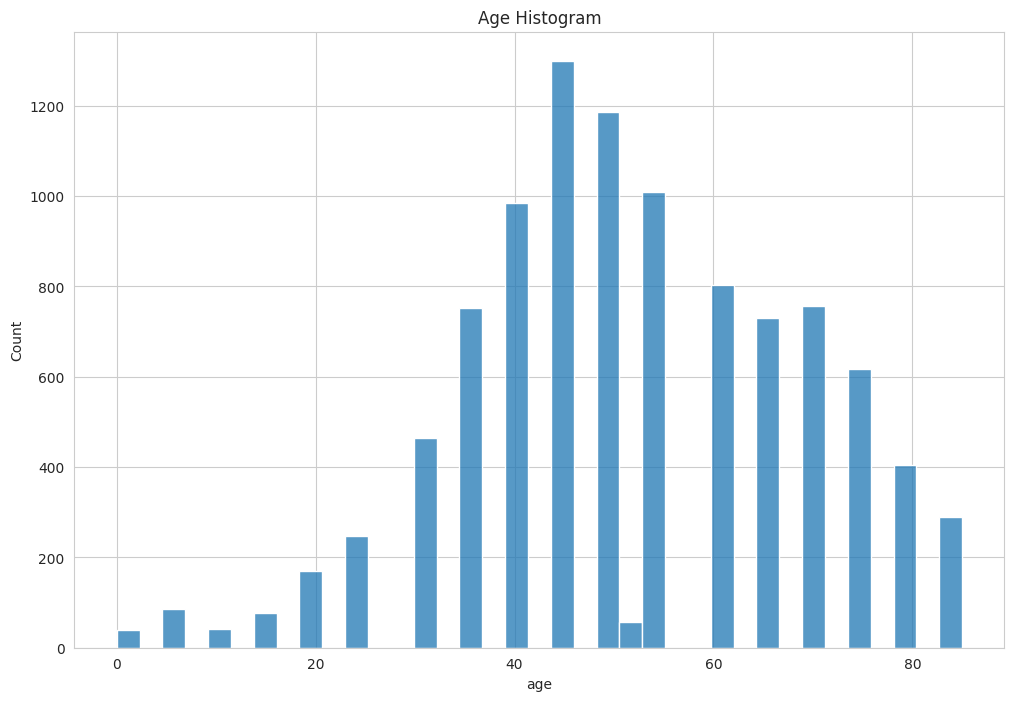

In [24]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age')
plt.title('Age Histogram')
plt.show()

Resizing the Image

In [70]:
size = (64, 64)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size))/ 255)

In [71]:
df['image'].shape


(10015,)

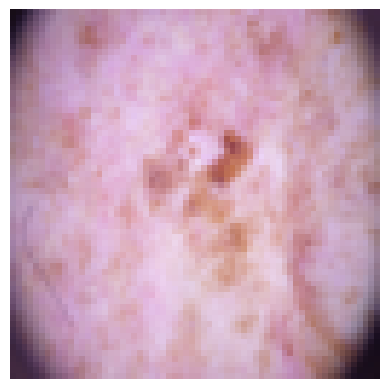

In [26]:
arr = df.iloc[1]['image']
#Image.fromarray(arr)
plt.imshow(arr)
plt.axis('off')
plt.show()

Pictorial representation of Images of dataset

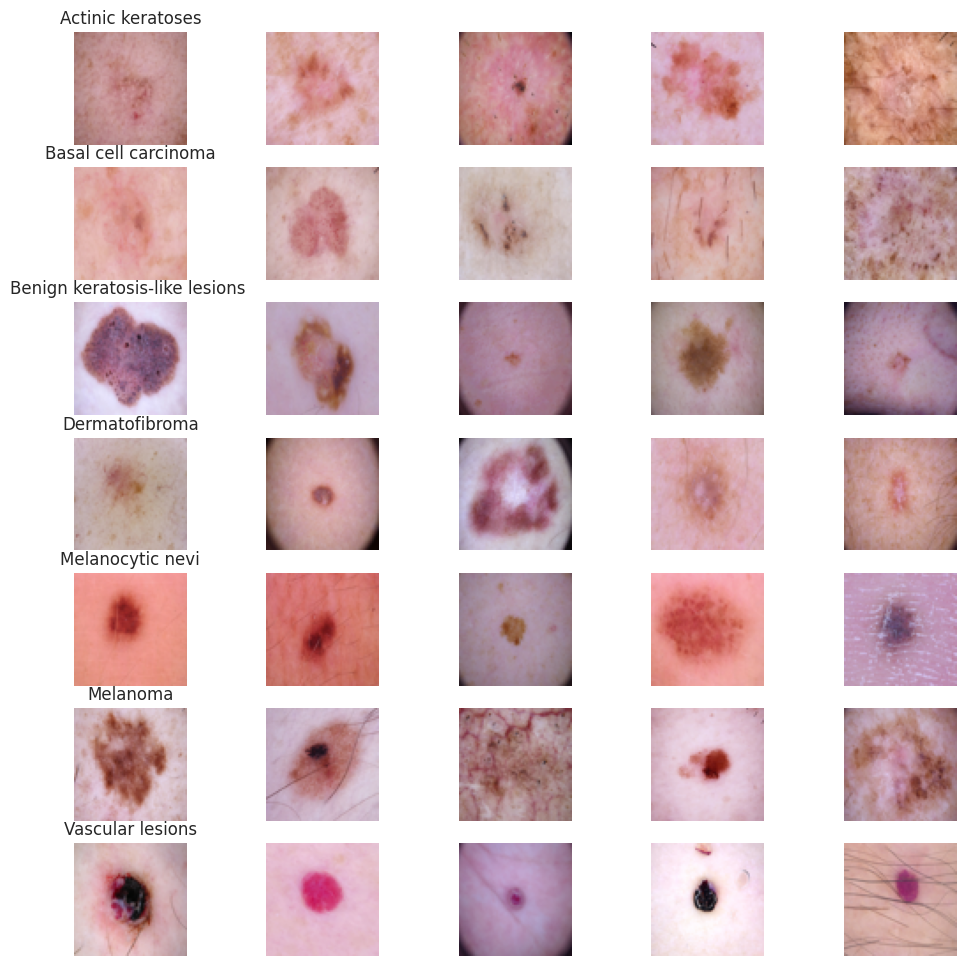

In [27]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [28]:
df['dx'].value_counts()

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


**Data Augmentation**

In [29]:
def aug_brightness(img_arr):
    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [30]:
def aug_contrast(img_arr):
    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [31]:
def aug_flip_left_right(img_arr):
    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)

    return aug_arr

In [32]:
def aug_flip_up_down(img_arr):
    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)

    return aug_arr

In [33]:
def aug_hue(img_arr):
    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [34]:
def aug_saturation(img_arr):
    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)
    aur_arr = np.array(aug_arr)

    return aug_arr

In [40]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [35]:
from IPython.display import clear_output
def random_augmentation(images, dx, num_of_samples):
    new_images = []
    all_indices = []
    while (len(new_images) < num_of_samples):
        indices = np.random.randint(images.shape[0], size=6)
        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))
        r = [np.array(tensor) for tensor in r]
        new_images.extend(r)
        all_indices.extend(indices)
        clear_output(wait=True)
        print(str(len(new_images)) + '/' + str(num_of_samples))

    new_images = pd.DataFrame({'dx': dx, 'image': new_images})

    return all_indices, new_images

In [36]:
df_df = df[df['dx'] == 'df']
vasc_df = df[df['dx'] == 'vasc']
akiec_df = df[df['dx'] == 'akiec']
bcc_df = df[df['dx'] == 'bcc']
bkl_df = df[df['dx'] == 'bkl']
mel_df = df[df['dx'] == 'mel']

In [37]:
seed = (4,2)

In [41]:
df_images = df_df['image']
df_indices, df_new_images = random_augmentation(df_images, 'df', 700)

702/700


In [42]:
vasc_images = vasc_df['image']
vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', 700)

702/700


In [43]:
akiec_images = akiec_df['image']
akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', 1000)

1002/1000


In [44]:
bcc_images = bcc_df['image']
bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', 1200)

1200/1200


In [45]:
bkl_images = bkl_df['image']
bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', 1400)

1404/1400


In [46]:
mel_images = mel_df['image']
mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', 1400)

1404/1400


In [47]:
new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images], axis=0).reset_index(drop=True)
aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [48]:
pd.DataFrame(aug_df['dx'].value_counts()).reset_index()

,dx,count
0,nv,6705
1,mel,2517
2,bkl,2503
3,bcc,1714
4,akiec,1329
5,vasc,844
6,df,817


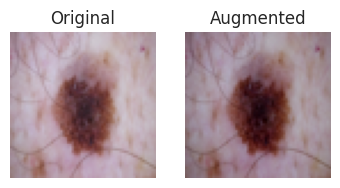

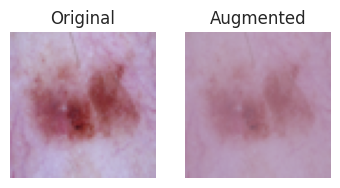

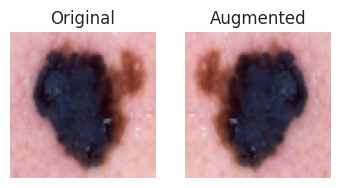

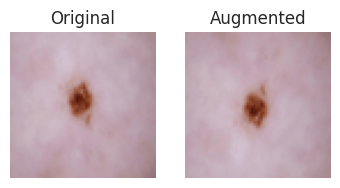

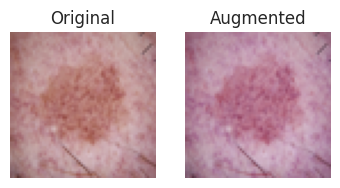

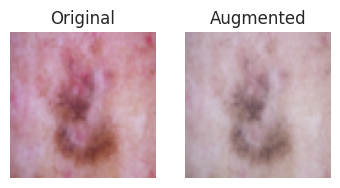

In [49]:
for i in range(12, 18):
    plt.subplot(1, 3, 1)
    plt.imshow(mel_df['image'].iloc[mel_indices[i]])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mel_new_images['image'].iloc[i])
    plt.title('Augmented')
    plt.axis('off')

    plt.show()

In [50]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
aug_df['label'] = labelEncoder.fit_transform(aug_df['dx'])

In [53]:
from sklearn.model_selection import train_test_split

x = np.asarray(aug_df['image'].to_list())
y = to_categorical(aug_df['label'], num_classes=7)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=True)


**Model**

In [75]:
# Ensure all Keras imports are from tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [77]:
!pip install -q efficientnet

In [78]:

# Import EfficientNetB4 properly
from efficientnet.tfkeras import EfficientNetB4

# Define the model using EfficientNetB4
model = Sequential([
    EfficientNetB4(include_top=False, weights='imagenet', input_shape=(64, 64, 3)),
    Flatten(),
    Dropout(rate=0.5),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(rate=0.5),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(rate=0.5),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier')
])

# Compile the model with a lower learning rate
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)



In [79]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), callbacks=[EarlyStopping(patience=5), reduce_lr])

Epoch 1/100


  0%|          | 0/16429 [08:05<?, ?it/s]


206/206 ━━━━━━━━━━━━━━━━━━━━ 322s 717ms/step - accuracy: 0.1465 - loss: 2.4571 - val_accuracy: 0.3363 - val_loss: 1.8097 - learning_rate: 1.0000e-04
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 45s 97ms/step - accuracy: 0.2799 - loss: 1.9596 - val_accuracy: 0.4738 - val_loss: 1.4629 - learning_rate: 1.0000e-04
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.3830 - loss: 1.6357 - val_accuracy: 0.5161 - val_loss: 1.3540 - learning_rate: 1.0000e-04
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.4634 - loss: 1.4643 - val_accuracy: 0.5511 - val_loss: 1.2745 - learning_rate: 1.0000e-04
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.5174 - loss: 1.3317 - val_accuracy: 0.5736 - val_loss: 1.1860 - learning_rate: 1.0000e-04
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.5434 - loss: 1.2641 - val_accuracy: 0.6035 - val_loss: 1.1184 - learning_rate: 1.0000e-04
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step

In [80]:
# Save the model to a specified directory
model_save_path = '/content/drive/MyDrive/Model_weight/skin_cancer_model.h5'
model.save(model_save_path)

# Save the model architecture to a JSON file
model_json = model.to_json()
json_save_path = '/content/drive/MyDrive/Model_weight/skin_cancer_model.json'
with open(json_save_path, 'w') as json_file:
    json_file.write(model_json)


In [81]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9119 - loss: 0.3715
Test Accuracy: 0.9074863195419312
Test Loss: 0.39368936419487


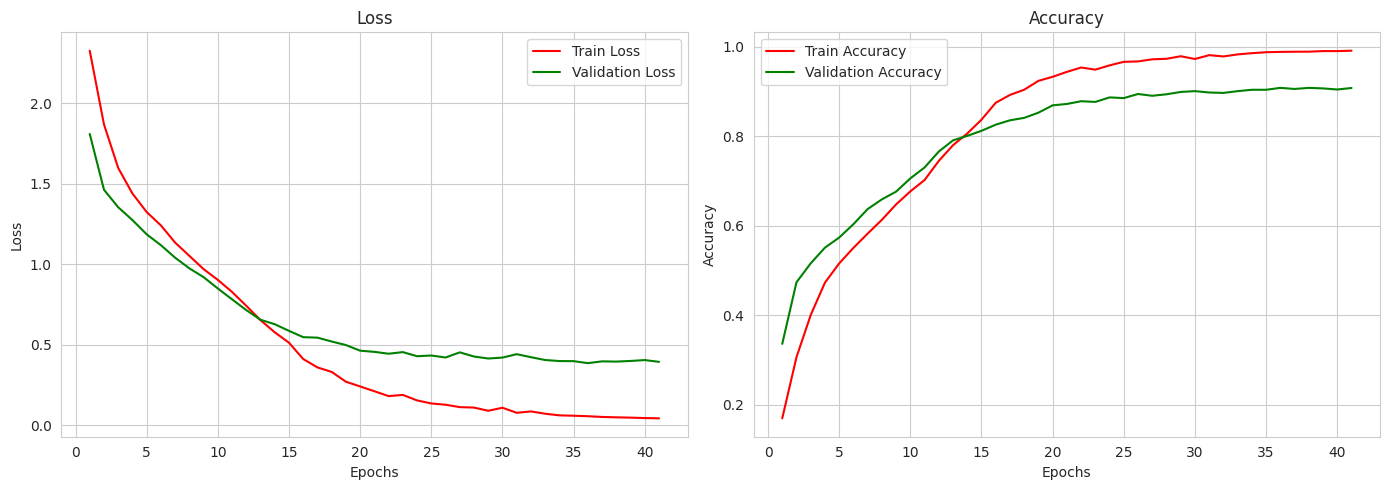

In [82]:
# Plot training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [84]:
class_names = ['Melanoma', 'Nevus', 'Basal Cell Carcinoma', 'Actinic Keratosis', 'Benign Keratosis', 'Dermatofibroma', 'Vascular Lesion']


In [85]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities for each class
y_probs = model.predict(x_test)
# Convert probabilities to class labels
y_pred = np.argmax(y_probs, axis=1)

# Generate classification report with 3 decimal places
report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=class_names, digits=3)

print("Classification Report:")
print(report)


103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classification Report:
                      precision    recall  f1-score   support

            Melanoma      0.922     0.940     0.931       265
               Nevus      0.902     0.926     0.914       367
Basal Cell Carcinoma      0.840     0.865     0.852       473
   Actinic Keratosis      0.931     0.988     0.958       163
    Benign Keratosis      0.853     0.842     0.847       518
      Dermatofibroma      0.940     0.917     0.928      1337
     Vascular Lesion      0.982     0.988     0.985       163

            accuracy                          0.907      3286
           macro avg      0.910     0.924     0.917      3286
        weighted avg      0.908     0.907     0.908      3286



103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


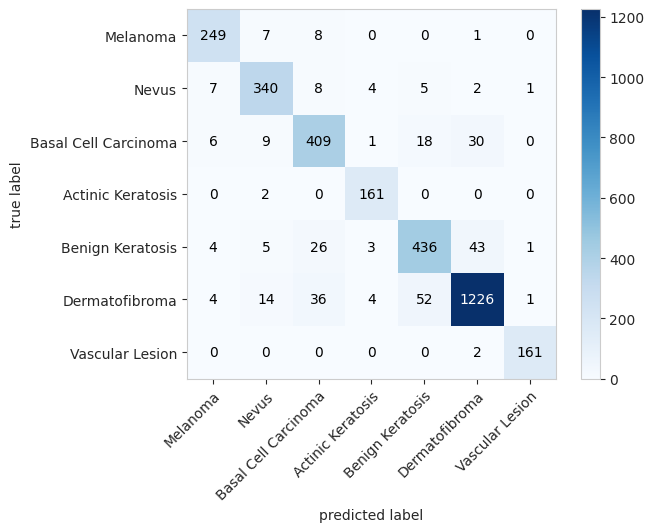

In [91]:
from mlxtend.plotting import plot_confusion_matrix
predictions = model.predict(x_test)
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
cm
cm_plot_labels = ['Melanoma', 'Nevus', 'Basal Cell Carcinoma', 'Actinic Keratosis', 'Benign Keratosis', 'Dermatofibroma', 'Vascular Lesion']

fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=cm_plot_labels, colorbar=True)
plt.show()

In [92]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 249    7    8    0    0    1    0]
 [   7  340    8    4    5    2    1]
 [   6    9  409    1   18   30    0]
 [   0    2    0  161    0    0    0]
 [   4    5   26    3  436   43    1]
 [   4   14   36    4   52 1226    1]
 [   0    0    0    0    0    2  161]]


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


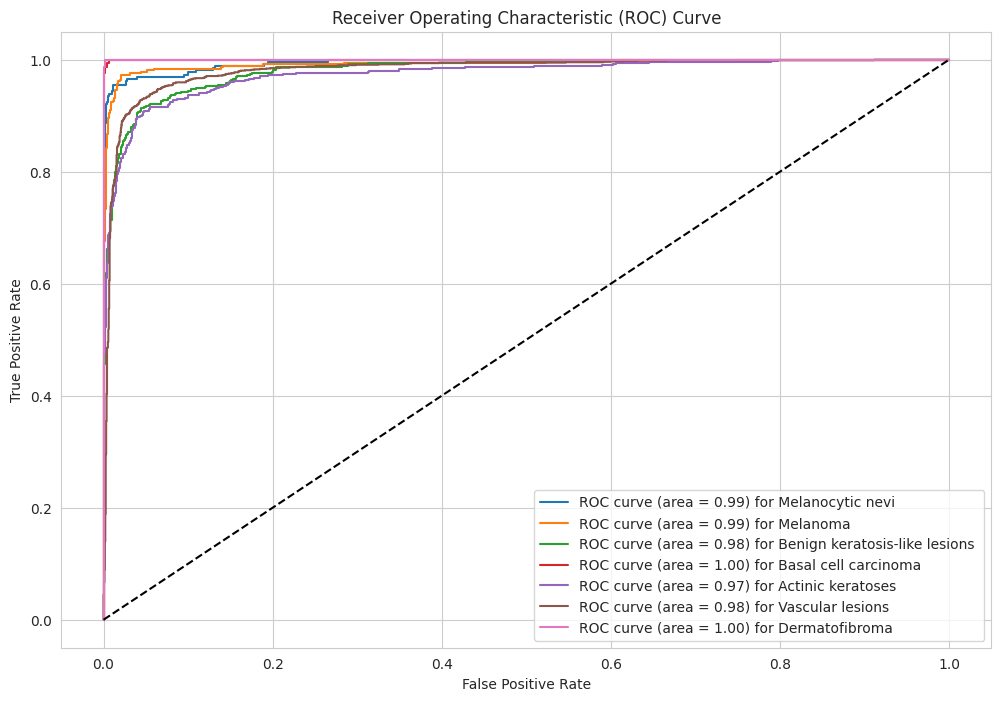

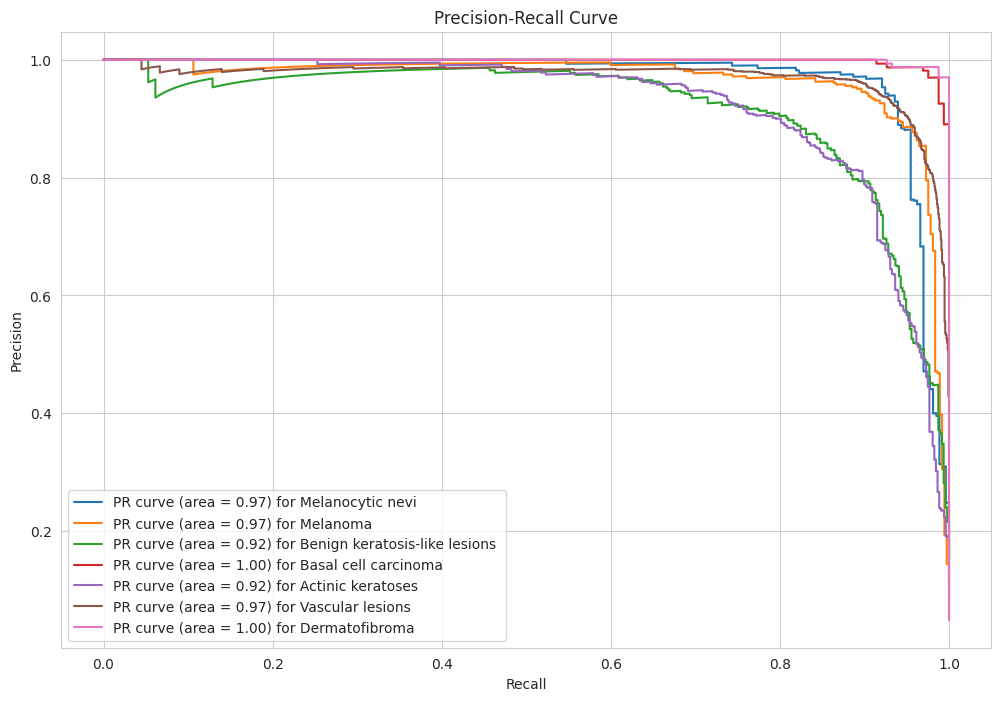

In [87]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Predict probabilities for each class
y_probs = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(lesion_type_dict)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute Precision-Recall curve and area for each class
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(len(lesion_type_dict)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_probs[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot ROC curve
plt.figure(figsize=(12, 8))
for i in range(len(lesion_type_dict)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {list(lesion_type_dict.values())[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(12, 8))
for i in range(len(lesion_type_dict)):
    plt.plot(recall[i], precision[i], label=f'PR curve (area = {pr_auc[i]:.2f}) for {list(lesion_type_dict.values())[i]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


In [88]:
true_positives = np.diag(cm)
false_positives = np.sum(cm, axis=0) - true_positives
false_negatives = np.sum(cm, axis=1) - true_positives
true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

Sensitivity (True Positive Rate): [0.93962264 0.92643052 0.86469345 0.98773006 0.84169884 0.91697831
 0.98773006]
Specificity (True Negative Rate): [0.99304866 0.98732443 0.9722716  0.99615754 0.97290462 0.95997948
 0.99903939]
